# Assignment: Classifying Text

In [109]:
import re
import numpy as np
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import pandas as pd
#import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.model_selection import cross_val_score
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

## Crosstraining

**Test how well your model, when trained on one dataset, performs on the other.**

**The idea is to consider the situation where you have labels for one context, but not for the other. So you must train your model your "source context" and hope it generalizes well to your "target context", where you have no labels!**

**Use the two datasets available in `sentiment/yelp.csv` (online restaurant reviews from Yelp) and `sentiment/movies.csv` (online movie reviews from IMDB). Both have a column called `text` with the text of the review and a column called `positive` which should be your outcome. No other variables are needed.**

**To do this, make sure that you:**

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on.
3. Use the "predict" of your model to see how well it did on the second dataset.

**How well does your model generalize from one to the other? What does this say about "sentiment"?****

In [118]:
class CrossTraining():

    def __init__(self):
        self.stemmer = SnowballStemmer("english")
        self.stop_words = get_stop_words('en')

    def load_data(self):
        self.yelps = pd.read_csv('sentiment/yelps.csv')
        self.movies = pd.read_csv('sentiment/movies.csv')

    def preprocess(self, doc):
        # remove stopwords:
        doc = [x for x in doc.split() if x not in self.stop_words]
        doc = ' '.join(doc)
        # stemming & lower:
        doc = re.sub(re.compile(r'[^\w|\s]'), '', doc)
        doc = [self.stemmer.stem(word).lower() for word in doc.split()]
        doc = ' '.join(doc)
        return doc

    def vectorize(self, min_df, max_df, use_idf=False):
        vectorizer = TfidfVectorizer(min_df=min_df,
                                 max_df=max_df,
                                 preprocessor=self.preprocess,
                                 #stop_words='english',
                                 use_idf=use_idf,
                                 norm='l2')
        return vectorizer

    def transform_data(self, vectorizer, yelps_is_train=True, use_X_test=False):
        # define X, y, X_test, y_test:
        if yelps_is_train:
            df_train = self.yelps
            df_test = self.movies
        else:
            df_train = self.movies
            df_test = self.yelps
        # define input for vectorizer:
        if use_X_test:
            #df_all = pd.concat([df_train.text, df_test.text])
            X_fit = vectorizer.fit(df_test.text)
        else:
            X_fit = vectorizer.fit(df_train.text)
        # transform X:
        X = X_fit.transform(df_train.text)
        #X = vectorizer.fit_transform(df_train.text)
        
        X = np.asarray(X.todense())
        y = df_train.positive
        y = [int(x == 'True') for x in y]
        # define X_test and y_test:
        y_test = df_test.positive
        y_test = [int(x == 'True') for x in y_test]
        X_test = X_fit.transform(df_test.text)
        return X, y, X_test, y_test

    def get_scores(self, X, y, X_test, y_test):
        # get cv_scores:
        lreg = LogisticRegression()
        cv_score = np.mean(cross_val_score(lreg, X, y, cv=3))
        # get out-of-sample scores:
        lreg.fit(X, y)
        out_of_sample_score = lreg.score(X_test, y_test)
        print(f'CV Score: {round(cv_score,3)}, Out-of-Sample Score: {round(out_of_sample_score,3)}')
        return cv_score, out_of_sample_score
    
    def main(self, use_X_test=False, yelps_is_train=True):
        
        self.load_data()
        
        vectorizer = self.vectorize(min_df=0.03, max_df=0.8, use_idf=False)
        
        X, y, X_test, y_test = self.transform_data(vectorizer, use_X_test=use_X_test, yelps_is_train=yelps_is_train)
        
        cv_score, out_of_sample_score = self.get_scores(X, y, X_test, y_test)
        
        return X, y, X_test, y_test, cv_score, out_of_sample_score

### train on yelps, test on movies:

In [119]:
#%%time
crosst = CrossTraining()
_, _, _, _, cv_score_1, out_of_sample_score_1 = crosst.main()

CV Score: 0.923, Out-of-Sample Score: 0.754


The idea is to compare a cross-validated out of sample score (only using the train set) with the score one gets by using the other dataset (here movies in stead of yelps). If the two datasets come from the same distribution, this score ought to be very similar. But quite evidently this is not the case here: the cross-validation score is around 17% higher than the out of sample score, therefore we can conclude that this alternative dataset (movies) is an unreliable metric to evaluate our model.

### train on movies, test on yelps:

In [120]:
#%%time
crosst = CrossTraining()
_, _, _, _, cv_score_2, out_of_sample_score_2 = crosst.main(yelps_is_train=False)

CV Score: 0.852, Out-of-Sample Score: 0.843


When using movies as train data and yelps as test data my results change and the cv score and out of sample score are very similar. This makes sense if we assume that the movies dataset is a more diverse dataset, i.e. it contains most of the information/words/sentiment that the yelps contains, but NOT VICE VERSA (which would explain the lack of generalizability when training on yelps)!

## Crosstraining 2

**Try to improve your transfer score using the unlabelled target data, P(X). What could you learn from the target context (without using the labels, only from the X) that might help you when training your model on your source context? How can you construct a feature space in your source context that generalizes better?**

What we can do differently here is to use X_test instead of X_train to fit the vectorizer. This might help if we think that a lot of information gets lost if, when creating the feature space, we don't take into account typical words from the test set that don't appear frequently or don't appear at all in the train set.

With this change we pick better features for our prediction, but the values for these features will still be biased since we trained our classifier with data that comes from a different distribution.

BTW: I tried also fitting both datasets together into the vectorizer but the results weren't very different/better when evaluating on the test set. It goes without saying that in order for our model to be generalizable to other unknown data one might have to collect as much data as possible and therefore fit the concatenation of both datasets into the vectorizer.

### train on yelps, test on movies:

In [121]:
#%%time
crosst = CrossTraining()
_, _, _, _, cv_score_2_1, out_of_sample_score_2_1 = crosst.main(use_X_test=True)

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CV Score: 0.917, Out-of-Sample Score: 0.782


/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### train on movies, test on yelps:

In [122]:
#%%time
crosst = CrossTraining()
_, _, _, _, cv_score_2_2, out_of_sample_score_2_2 = crosst.main(use_X_test=True, yelps_is_train=False)

CV Score: 0.816, Out-of-Sample Score: 0.821


## plotting everything:

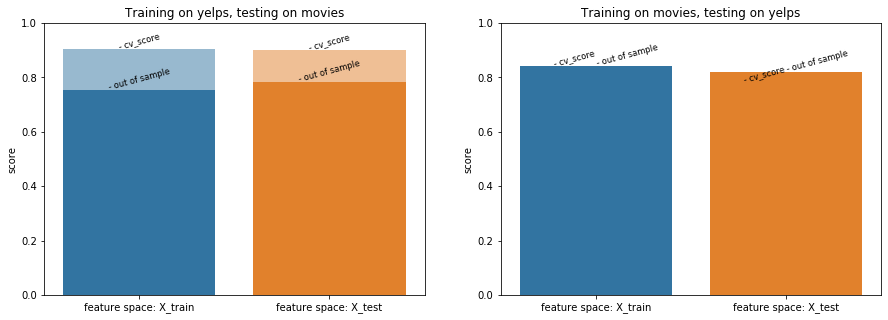

In [128]:
# settings:
labels = ['feature space: X_train', 'feature space: X_test']
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('Training on yelps, testing on movies')
ax2.set_title('Training on movies, testing on yelps')
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
# first subplot:
g1 = sns.barplot(x=labels, y=[in_sample_score_1, in_sample_score_2_1], alpha=0.5, ax=ax1)
for i, row in enumerate([in_sample_score_1, in_sample_score_2_1]):
    g1.text(x=i, y=row, s='- cv_score', color='black', ha="center", size='small', rotation=15)

g1 = sns.barplot(x=labels, y=[out_of_sample_score_1, out_of_sample_score_2_1], ax=ax1)
for i, row in enumerate([out_of_sample_score_1, out_of_sample_score_2_1]):
    g1.text(x=i, y=row, s='- out of sample', color='black', ha="center", size='small', rotation=15)
g1.set_ylabel('score')

# second subplot:
g2 = sns.barplot(x=labels, y=[in_sample_score_2, in_sample_score_2_2], alpha=0.5, ax=ax2)
for i, row in enumerate([in_sample_score_2, in_sample_score_2_2]):
    g2.text(x=i, y=row, s='- cv_score', color='black', ha="right", size='small', rotation=15)

g2 = sns.barplot(x=labels, y=[out_of_sample_score_2, out_of_sample_score_2_2], ax=ax2)
for i, row in enumerate([out_of_sample_score_2, out_of_sample_score_2_2]):
    g2.text(x=i, y=row, s='- out of sample', color='black', ha="left", size='small', rotation=15)
g2.set_ylabel('score')

plt.show()

On the left subplot you see that fitting X_test to the vectorizer helps a bit when training on the yelps and testing on the movies dataset: The gap between cross-validation and out-of-sample performance shrinks a bit, but not substantially.

When training on the movies and testing on the yelps dataset, however, (right subplot) things are a bit different: The cross-validation and out-of-sample performance more or less coincide in both cases and using the test data as our feature space does not help but worsen the performance for both out-of-sample approaches.
This makes sense if the following holds: The movies dataset is a more diverse dataset, i.e. it contains most of the information/words/sentiment that the yelps contains, but NOT VICE VERSA! Therefore it is better to train on the movies dataset and also use the feature space of the movies dataset since it contains better (more generalizable) info on sentiment.
PS: Results are robust to various specifications of min_df and normalizing/not normalizing within the vectorization.